In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 11 21:47:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    41W / 250W |   2211MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers import LeakyReLU, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

class DCGAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 64
    optimizer = Adam(0.0001, 0.5)
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                                optimizer=Adam(0.0002, 0.5),
                                metrics=['accuracy'])
    self.generator = self.build_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):
      generator = Sequential()
      dropout = 0.4
      depth = 64+64+64+64
      dim = 7
      # In: 100
      # Out: dim x dim x depth
      generator.add(Dense(dim*dim*depth, input_dim=64))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
      generator.add(Reshape((dim, dim, depth)))
      generator.add(Dropout(dropout))

      # In: dim x dim x depth
      # Out: 2*dim x 2*dim x depth/2
      generator.add(UpSampling2D())
      generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))

      generator.add(UpSampling2D())
      generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))

      generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))

      # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
      generator.add(Conv2DTranspose(1, 5, padding='same'))
      generator.add(Activation('sigmoid'))
      generator.summary()
      return generator

  def build_discriminator(self):
      discriminator = Sequential()
      depth = 64
      dropout = 0.4
      # In: 28 x 28 x 1, depth = 1
      # Out: 14 x 14 x 1, depth=64
      input_shape = (self.img_rows, self.img_cols, self.channels)
      discriminator.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
          padding='same'))
      discriminator.add(LeakyReLU(alpha=0.2))
      discriminator.add(Dropout(dropout))

      discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
      discriminator.add(LeakyReLU(alpha=0.2))
      discriminator.add(Dropout(dropout))

      discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
      discriminator.add(LeakyReLU(alpha=0.2))
      discriminator.add(Dropout(dropout))

      discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
      discriminator.add(LeakyReLU(alpha=0.2))
      discriminator.add(Dropout(dropout))

      # Out: 1-dim probability
      discriminator.add(Flatten())
      discriminator.add(Dense(1))
      discriminator.add(Activation('sigmoid'))
      discriminator.summary()
      return discriminator

  def train(self, epochs, batch_size=32, sample_interval=1000):
      (X_train, _), (_, _) = mnist.load_data()
      X_train = X_train / 127.5 - 1.
      X_train = np.expand_dims(X_train, axis=3)
      valid = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))
      for epoch in range(epochs):
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
          g_loss = self.combined.train_on_batch(noise, valid)
          gen_imgs = self.generator.predict(noise)
          d_loss_real = self.discriminator.train_on_batch(imgs, valid)
          d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
          if epoch % sample_interval == 0:
            self.generate_numbers(epoch)
			
  def generate_numbers(self, epoch):
    noise = np.random.normal(0, 1, (1, gan.latent_dim))
    predictions = gan.generator.predict(noise)
    print(predictions.shape)
    print("Reshaping")
    generated_seq = np.reshape(predictions[0], (28,28))
    print(generated_seq.shape)
    plt.figure(figsize = (5,5))
    plt.imshow(generated_seq,aspect='auto',cmap='gray')
    #Path to be created in Google Drive to avoid failure
    plt.savefig("/content/drive/My Drive/DL/GAN/Results/DCGAN_MNIST/%d.png" % epoch)
    plt.show()
    plt.close()
      

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.733620, acc.: 10.94%] [G loss: 0.698749]
(1, 28, 28, 1)
Reshaping
(28, 28)


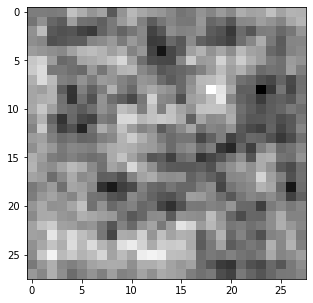

1 [D loss: 0.585659, acc.: 98.44%] [G loss: 0.703315]
2 [D loss: 0.403575, acc.: 100.00%] [G loss: 0.802828]
3 [D loss: 0.171308, acc.: 100.00%] [G loss: 1.108288]
4 [D loss: 0.039438, acc.: 100.00%] [G loss: 1.983117]
5 [D loss: 0.006224, acc.: 100.00%] [G loss: 3.501226]
6 [D loss: 0.001476, acc.: 100.00%] [G loss: 4.610466]
7 [D loss: 0.000671, acc.: 100.00%] [G loss: 4.787988]
8 [D loss: 0.000407, acc.: 100.00%] [G loss: 4.752668]
9 [D loss: 0.000250, acc.: 100.00%] [G loss: 4.395399]
10 [D loss: 0.000159, acc.: 100.00%] [G loss: 4.214748]
11 [D loss: 0.000342, acc.: 100.00%] [G loss: 3.894940]
12 [D loss: 0.000051, acc.: 100.00%] [G loss: 3.673766]
13 [D loss: 0.000087, acc.: 100.00%] [G loss: 3.491244]
14 [D loss: 0.000072, acc.: 100.00%] [G loss: 3.268153]
15 [D loss: 0.000094, acc.: 100.00%] [G loss: 3.138768]
16 [D loss: 0.000169, acc.: 100.00%] [G loss: 3.022709]
17 [D loss: 0.000980, acc.: 100.00%] [G loss: 2.922107]
18 [D loss: 0.000037, acc.: 100.00%] [G loss: 2.738424]
19

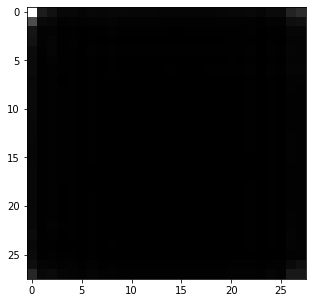

1001 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.146957]
1002 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.390545]
1003 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.294554]
1004 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.202900]
1005 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.336393]
1006 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.230276]
1007 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.424502]
1008 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.496759]
1009 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.157377]
1010 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.203196]
1011 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.244963]
1012 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.316151]
1013 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.307211]
1014 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.190933]
1015 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.399864]
1016 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.359861]
1017 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.40954

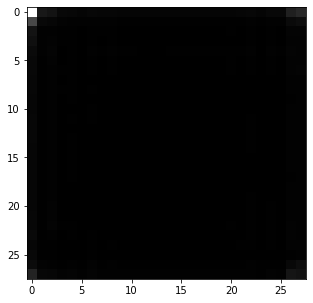

2001 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.822239]
2002 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.073326]
2003 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.886074]
2004 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.058050]
2005 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.896864]
2006 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.044287]
2007 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.938927]
2008 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.278969]
2009 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.120255]
2010 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.934111]
2011 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.849712]
2012 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.927021]
2013 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.310732]
2014 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.010284]
2015 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.293568]
2016 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.094475]
2017 [D loss: 0.000000, acc.: 100.00%] [G loss: 17.05668

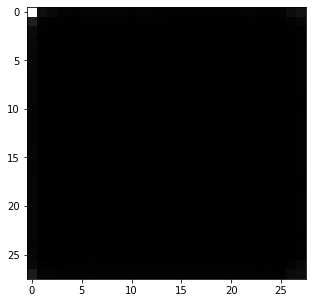

3001 [D loss: 0.000007, acc.: 100.00%] [G loss: 11.820129]
3002 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.877430]
3003 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.814436]
3004 [D loss: 0.000006, acc.: 100.00%] [G loss: 11.885305]
3005 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.876608]
3006 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.956849]
3007 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.967247]
3008 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.757055]
3009 [D loss: 0.000004, acc.: 100.00%] [G loss: 11.973221]
3010 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.911989]
3011 [D loss: 0.000005, acc.: 100.00%] [G loss: 12.017097]
3012 [D loss: 0.000006, acc.: 100.00%] [G loss: 11.773331]
3013 [D loss: 0.000004, acc.: 100.00%] [G loss: 11.911975]
3014 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.969715]
3015 [D loss: 0.000005, acc.: 100.00%] [G loss: 11.671703]
3016 [D loss: 0.000004, acc.: 100.00%] [G loss: 11.617104]
3017 [D loss: 0.000004, acc.: 100.00%] [G loss: 11.91059

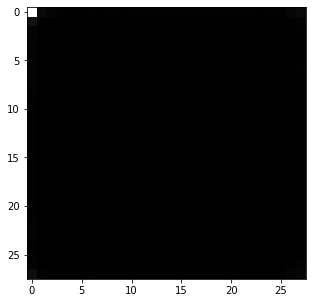

4001 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.425799]
4002 [D loss: 0.000002, acc.: 100.00%] [G loss: 13.511218]
4003 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.273890]
4004 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.441066]
4005 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.395047]
4006 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.572870]
4007 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.527670]
4008 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.424332]
4009 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.332980]
4010 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.447895]
4011 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.594304]
4012 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.489407]
4013 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.092251]
4014 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.324713]
4015 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.687510]
4016 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.264891]
4017 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.34647

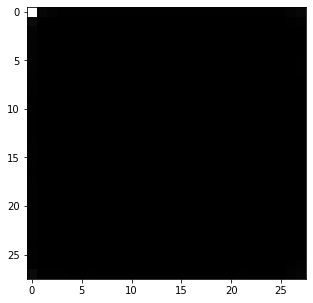

5001 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.608696]
5002 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.460669]
5003 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.587919]
5004 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.707482]
5005 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.594297]
5006 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.650234]
5007 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.748682]
5008 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.913088]
5009 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.437329]
5010 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.874208]
5011 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.812441]
5012 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.677494]
5013 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.656607]
5014 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.914158]
5015 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.670511]
5016 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.781379]
5017 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.68236

In [0]:
gan = DCGAN()
gan.train(epochs=100000, batch_size=32, sample_interval=1000)